In [2]:
import time
import optuna
import numpy as np
import pandas as pd
from numpy import std
from numpy import mean
import scikitplot as skplt
import matplotlib.pyplot as plt

from random import randint
from tensorflow import keras 

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score, plot_confusion_matrix

ds = pd.read_csv('TRNcod.xls', delimiter = "\t")

# Shuffle no dataset
ds = ds.sample(frac=1).reset_index(drop=True)

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def compute_performance_metrics_sem_plot(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        # skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        # plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

In [ ]:
# print([d for d in ds.columns])

In [3]:
# inadimplentes = pd.DataFrame(list(filter(lambda x: x == 1, ds['IND_BOM_1_2'])))

# Selecionando quem é inadimplente
inadimplentes = ds[ds['IND_BOM_1_2'] == 1]

# Selecionando quem é adimplente
adimplente = ds[ds['IND_BOM_1_2'] == 0]

global treino_ina
global teste_ina
global valid_ina
global treino_adi
global teste_adi
global valid_adi


# Dividindo datasets
treino_ina = inadimplentes[:int(len(inadimplentes)/2)]
teste_ina  = inadimplentes[int(len(inadimplentes)/2):int((len(inadimplentes)*3)/4)]
valid_ina  = inadimplentes[int((len(inadimplentes)*3)/4):]

treino_adi = adimplente[:int(len(adimplente)/2)]
teste_adi  = adimplente[int(len(adimplente)/2):int((len(adimplente)*3)/4)]
valid_adi  = adimplente[int((len(adimplente)*3)/4):]

# Equalizando tamanho de datasets treino e validação dos inadimplentes ao de adimplentes
treino_ina = treino_ina.loc[treino_ina.index.repeat(2)].drop('INDEX', axis=1)
treino_ina["COPIA"] = treino_ina.duplicated()
treino_ina.sort_values(by="COPIA", inplace=True, ignore_index=True)
treino_ina = treino_ina.iloc[ : ( len(treino_adi) - len(treino_ina) ), :  ]
treino_ina.drop(columns=["COPIA"], axis=1, inplace=True)

treino_adi.drop(columns=['INDEX'], axis=1, inplace=True)

valid_ina  = valid_ina.loc[valid_ina.index.repeat(2)].drop('INDEX', axis=1)
valid_ina["COPIA"] = valid_ina.duplicated()
valid_ina.sort_values(by="COPIA", inplace=True, ignore_index=True)
valid_ina = valid_ina.iloc[ : ( len(valid_adi) - len(valid_ina) ), :  ]
valid_ina.drop(columns=["COPIA"], axis=1, inplace=True)
# Fim da equalização

print('Tamanhos de inadimplentes: \nTreino: {}\nTeste: {}\nValidação: {}\n'.format(len(treino_ina.values), len(teste_ina.values), len(valid_ina.values)))
print('Tamanhos de adimplentes: \nTreino: {}\nTeste: {}\nValidação: {}\n'.format(len(treino_adi.values), len(teste_adi.values), len(valid_adi.values)))
print('Colunas: {}'.format(len([d for d in ds.columns])))
ds.drop(labels="INDEX", axis=1, inplace=True)

/home/vitor/.local/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Tamanhos de inadimplentes: 
Treino: 127549
Teste: 33524
Validação: 63775

Tamanhos de adimplentes: 
Treino: 127549
Teste: 63774
Validação: 63775

Colunas: 246


In [3]:
# https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on

# # Create correlation matrix
# corr_matrix = ds.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find features with correlation greater than 0.89
# to_drop = [column for column in upper.columns if any(upper[column] > 0.89)]

# # Drop features 
# # ds.drop(to_drop, axis=1, inplace=True)
# ds.columns


# Colunas mais correlacionadas
# l = []
# for c in ds.columns[:-1]:
#     l.append({c: ds[c].corr(ds['IND_BOM_1_1'])})
#     # if (ds[c].corr(ds['IND_BOM_1_1']) > 0.0):
#         # print( c, ds[c].corr(ds['IND_BOM_1_1']) )
# l.sort(key=lambda x: list(x.values())[0])
# print(l)

In [9]:
# Passos a fazer
# Esquema de experimentação (passo a passo do que vamos testar)
# MLP & Random Forest

In [4]:
# https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/

from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow import keras

# MLP
model = Sequential()

# Dropout
layer = Dropout(randint(0,100)/100)

# Regularização
# ???

ds_2 = ds
# ds_2 = ds.iloc[ 0:300, : ]

trY = ds_2['IND_BOM_1_2']
trX = ds_2.drop('IND_BOM_1_2', axis=1)
trX = trX.drop('IND_BOM_1_1', axis=1)
# trX = trX.drop(columns=['INDEX'], axis=1)

# Taxa de parada quando não mais evoluir

model.add(Dense(32,input_dim=243, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

# Parada antecipada caso em 10 epochs ela deixe de melhorar
paradinha = EarlyStopping(monitor='accuracy', mode='max', patience=10)

history = model.fit(trX, trY, epochs=10000, verbose=1, callbacks=[paradinha])

Epoch 1/10000
12163/12163 [==============================] - 9s 593us/step - loss: 0.6022 - accuracy: 0.6707
Epoch 2/10000
12163/12163 [==============================] - 7s 577us/step - loss: 0.5943 - accuracy: 0.6772
Epoch 3/10000
12163/12163 [==============================] - 7s 572us/step - loss: 0.5921 - accuracy: 0.6796
Epoch 4/10000
12163/12163 [==============================] - 7s 574us/step - loss: 0.5909 - accuracy: 0.6807
Epoch 5/10000
12163/12163 [==============================] - 7s 590us/step - loss: 0.5901 - accuracy: 0.6815
Epoch 6/10000
12163/12163 [==============================] - 7s 594us/step - loss: 0.5893 - accuracy: 0.6822
Epoch 7/10000
12163/12163 [==============================] - 8s 641us/step - loss: 0.5888 - accuracy: 0.6823
Epoch 8/10000
12163/12163 [==============================] - 7s 607us/step - loss: 0.5883 - accuracy: 0.6829
Epoch 9/10000
12163/12163 [==============================] - 7s 554us/step - loss: 0.5881 - accuracy: 0.6827
Epoch 10/10000
1216

In [6]:
def mlp_model(neuronios, camadas, dropout, learning_rate, ativacao, otimizador):
    model = Sequential()
    model.add(Dense(neuronios,input_dim=243, activation=ativacao))
    model.add(Dropout(dropout))
    if camadas==2:
        model.add(Dense(1, activation='sigmoid'))
    if otimizador =='adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif otimizador =='SGD':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    elif otimizador =='RMSprop':
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif otimizador =='Adadelta':
        opt = keras.optimizers.Adadelta(learning_rate=learning_rate)
        
    
    model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=opt)
    return model

n_neuronios = [8, 16, 32, 64, 128, 512, 1024]
n_camadas = [1, 2]
n_dropout = [0.4, 0.2, 0.1]
n_learning_rate = [0.1, 0.01, 0.001]
n_ativacao = ['tanh', 'relu']
n_otimizador = ['adam', 'SGD', 'RMSprop','Adadelta']

# ds_2 = ds
ds_2 = ds.iloc[ 0:10000, : ]

trY = ds_2['IND_BOM_1_2']
trX = ds_2.drop('IND_BOM_1_2', axis=1)
trX = trX.drop('IND_BOM_1_1', axis=1)
# trX = trX.drop('INDEX', axis=1)


model = mlp_model(32, 2, 0.1, 0.0005,'relu','adam')

paradinha = EarlyStopping(monitor='accuracy', mode='max', patience=10)
history = model.fit(trX, trY, epochs=10000, verbose=1, callbacks=[paradinha])



Epoch 1/10000
313/313 [==============================] - 1s 595us/step - loss: 0.6398 - accuracy: 0.6446
Epoch 2/10000
313/313 [==============================] - 0s 664us/step - loss: 0.6197 - accuracy: 0.6564
Epoch 3/10000
313/313 [==============================] - 0s 650us/step - loss: 0.6125 - accuracy: 0.6602
Epoch 4/10000
313/313 [==============================] - 0s 641us/step - loss: 0.6058 - accuracy: 0.6694
Epoch 5/10000
313/313 [==============================] - 0s 732us/step - loss: 0.6016 - accuracy: 0.6727
Epoch 6/10000
313/313 [==============================] - 0s 766us/step - loss: 0.5974 - accuracy: 0.6789
Epoch 7/10000
313/313 [==============================] - 0s 613us/step - loss: 0.5935 - accuracy: 0.6800
Epoch 8/10000
313/313 [==============================] - 0s 860us/step - loss: 0.5882 - accuracy: 0.6809
Epoch 9/10000
313/313 [==============================] - 0s 666us/step - loss: 0.5878 - accuracy: 0.6817
Epoch 10/10000
313/313 [==============================]

In [12]:
ds_3 = ds.iloc[ 50001:100001, :]
trY = ds_3['IND_BOM_1_2']
trX = ds_3.drop('IND_BOM_1_2', axis=1)
x, y = model.evaluate(trX, trY, verbose=1)

1563/1563 [==============================] - 1s 626us/step - loss: 5.3330 - accuracy: 0.6543


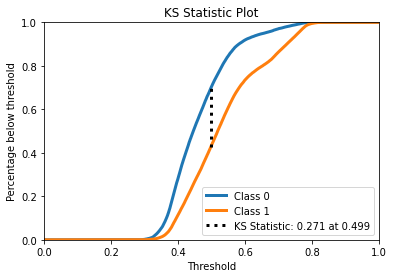

Acurácia: 0.6352097216777735
Recall: 0.5661152489219914
Precision: 0.6568902150576762
F1: 0.6081339430842955
AUROC: 0.6876080366943211
AURP: 0.6863975597334894


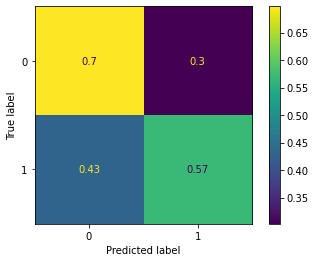

In [29]:
# Cuidado: usar esses parâmetros muito elevados, ou o default (100 estimadores e profundidade ilimitada) vai travar seu computador

# Parâmetros default:
# n_estimators=100, *,
# criterion="gini",
# max_depth=None,
# min_samples_split=2,
# min_samples_leaf=1,
# min_weight_fraction_leaf=0.,
# max_features="auto",
# max_leaf_nodes=None,
# min_impurity_decrease=0.,
# min_impurity_split=None,
# bootstrap=True,
# oob_score=False,
# n_jobs=None,
# random_state=None,
# verbose=0,
# warm_start=False,
# class_weight=None,
# ccp_alpha=0.0,
# max_samples=None

random_forest = RandomForestClassifier(n_estimators=128, max_depth=8, min_samples_leaf=2, min_samples_split=4, max_samples=randint(1,99)/100)
df_treino = treino_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(treino_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao = valid_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(valid_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao.drop(columns=['INDEX'], axis=1, inplace=True)

random_forest.fit(df_treino, [0]*len(treino_ina)+[1]*len(treino_adi))

rf_pred_class  = random_forest.predict(df_validacao)
rf_pred_scores = random_forest.predict_proba(df_validacao)

accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics([0]*len(valid_ina)+[1]*len(valid_adi), rf_pred_class, rf_pred_scores)
print('Acurácia: {}\nRecall: {}\nPrecision: {}\nF1: {}\nAUROC: {}\nAURP: {}'.format(accuracy, recall, precision, f1, auroc, aupr))

df_teste = teste_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(teste_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_teste.drop(columns=['INDEX'], axis=1, inplace=True)
plot_confusion_matrix(random_forest, df_teste, [0]*len(teste_ina)+[1]*len(teste_adi), normalize='true')

In [ ]:
ds_dropado = ds.drop(labels=['IND_BOM_1_2', 'IND_BOM_1_1'], axis=1)
df_treino = treino_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(treino_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao = valid_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(valid_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao.drop(columns=['INDEX'], axis=1, inplace=True)


def rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 8, 32)
    max_depth = trial.suggest_int("max_depth", 16, 64)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 8)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 8)
    random_forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion, bootstrap=True, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    print('Random Forest com {} estimadores e profundidade máxima {}, critério {}, min amostras de folhas {} e min divisão de amostras {}\n'.format(
        n_estimators, max_depth, criterion, min_samples_leaf, min_samples_split
    ))

    # start = time.time()
    # n_scores = cross_val_score(random_forest, ds_dropado, ds['IND_BOM_1_2'], scoring='accuracy', n_jobs=1, error_score='raise')
    # print('Acurácia e desvio padrão: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    # print("Tempo: ", format(time.time() - start, '.3f'), 's\n', sep='')

    random_forest.fit(df_treino, [0]*len(treino_ina)+[1]*len(treino_adi))
    rf_pred_class  = random_forest.predict(df_validacao)
    rf_pred_scores = random_forest.predict_proba(df_validacao)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics_sem_plot([0]*len(valid_ina)+[1]*len(valid_adi), rf_pred_class, rf_pred_scores)
    # print('Acurácia: {} | Recall: {} | Precision: {} | F1: {} | AUROC: {} | AURP: {}\n'.format(accuracy, recall, precision, f1, auroc, aupr))
    return accuracy

study_1 = optuna.create_study(direction="maximize")
study_1.optimize(rf, n_trials=64)

In [14]:
optuna.visualization.plot_optimization_history(study_1)

In [15]:
optuna.visualization.plot_slice(study_1)

In [16]:
optuna.visualization.plot_param_importances(study_1)

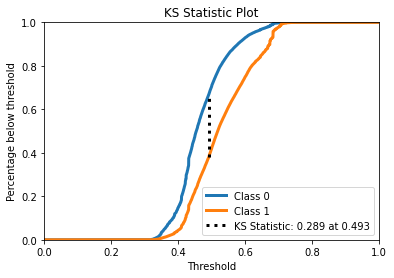

Acurácia: 0.6429086632693062
Recall: 0.5825950607604861
Precision: 0.6625120359473627
F1: 0.6199888200105125
AUROC: 0.6974324947088796
AURP: 0.6951357033971317




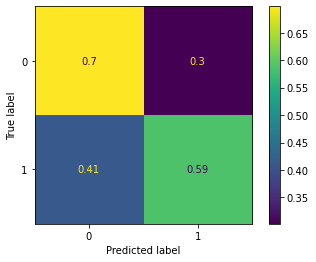

In [23]:
# Parâmetros default:
# *,loss='deviance', 
# learning_rate=0.1, 
# n_estimators=100,
# subsample=1.0, 
# criterion='friedman_mse', 
# min_samples_split=2,
# min_samples_leaf=1, 
# min_weight_fraction_leaf=0.,
# max_depth=3, 
# min_impurity_decrease=0.,
# min_impurity_split=None, 
# random_state=None, 
# max_features=None, verbose=0,
# max_leaf_nodes=None, 
# warm_start=False,
# validation_fraction=0.1, 
# n_iter_no_change=None, 
# tol=1e-4,
# ccp_alpha=0.0

ds_dropado = ds.drop(labels=['IND_BOM_1_2', 'IND_BOM_1_1'], axis=1)
df_treino = treino_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(treino_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao = valid_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(valid_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao.drop(columns=['INDEX'], axis=1, inplace=True)

gradient_boost = GradientBoostingClassifier(n_estimators = 8, max_depth = 8, learning_rate=0.1)
gradient_boost.fit(df_treino, [0]*len(treino_ina)+[1]*len(treino_adi))
gb_pred_class = gradient_boost.predict(df_validacao)
gb_pred_scores = gradient_boost.predict_proba(df_validacao)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics([0]*len(valid_ina)+[1]*len(valid_adi), gb_pred_class, gb_pred_scores)
print('Acurácia: {}\nRecall: {}\nPrecision: {}\nF1: {}\nAUROC: {}\nAURP: {}\n\n'.format(accuracy, recall, precision, f1, auroc, aupr))

df_teste = teste_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(teste_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_teste.drop(columns=['INDEX'], axis=1, inplace=True)
plot_confusion_matrix(gradient_boost, df_teste, [0]*len(teste_ina)+[1]*len(teste_adi), normalize='true')

In [13]:
study_2.best_trial

FrozenTrial(number=0, values=[0.6081301450411604], datetime_start=datetime.datetime(2021, 11, 26, 0, 43, 55, 308787), datetime_complete=datetime.datetime(2021, 11, 26, 0, 47, 35, 677947), params={'n_estimators': 15, 'max_depth': 46, 'loss': 'exponential', 'min_samples_leaf': 4, 'learning_rate': 0.1728224967273173, 'subsample': 0.2524415508422352}, distributions={'n_estimators': IntUniformDistribution(high=32, low=8, step=1), 'max_depth': IntUniformDistribution(high=64, low=16, step=1), 'loss': CategoricalDistribution(choices=('deviance', 'exponential')), 'min_samples_leaf': IntUniformDistribution(high=8, low=2, step=1), 'learning_rate': UniformDistribution(high=0.7, low=0.01), 'subsample': UniformDistribution(high=0.7, low=0.01)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)

In [ ]:
ds_dropado = ds.drop(labels=['IND_BOM_1_2', 'IND_BOM_1_1'], axis=1)
df_treino = treino_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(treino_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao = valid_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(valid_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao.drop(columns=['INDEX'], axis=1, inplace=True)

def gb(trial):
    n_estimators = trial.suggest_int("n_estimators", 8, 32)
    max_depth = trial.suggest_int("max_depth", 16, 64)
    loss = trial.suggest_categorical("loss", ["deviance", "exponential"])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 8)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.7)
    subsample = trial.suggest_float("subsample", 0.01, 0.7)
    print('Gradient Boosting com {} estimadores e profundidade máxima {}, critério {}, min amostras de folhas {}, subsample de {} e taxa de aprendizagem {}\n'.format(
        n_estimators, max_depth, loss, min_samples_leaf, subsample, learning_rate
    ))

    gradient_boost = GradientBoostingClassifier(n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf = min_samples_leaf, learning_rate = learning_rate, loss = loss, subsample = subsample)
    gradient_boost.fit(df_treino, [0]*len(treino_ina)+[1]*len(treino_adi))
    gb_pred_class = gradient_boost.predict(df_validacao)
    gb_pred_scores = gradient_boost.predict_proba(df_validacao)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics([0]*len(valid_ina)+[1]*len(valid_adi), gb_pred_class, gb_pred_scores)
    # print('Acurácia: {} | Recall: {} | Precision: {} | F1: {} | AUROC: {} | AURP: {}\n'.format(accuracy, recall, precision, f1, auroc, aupr))
    return accuracy

study_2 = optuna.create_study(direction="maximize")
study_2.optimize(gb, n_trials=64)

In [ ]:
optuna.visualization.plot_optimization_history(study_2)

In [ ]:
optuna.visualization.plot_slice(study_2)

In [ ]:
optuna.visualization.plot_param_importances(study_2)